<div id="Import Libraries">

# **Importing Libraries** 

In [1]:
import os
import gc
import cv2
import json
import time
import shutil
import numpy as np
from tqdm import tqdm
import mediapipe as mp
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from concurrent.futures import ThreadPoolExecutor
from IPython.display import clear_output, FileLink
import keras
from PIL import Image, ImageOps
import pandas as pd

In [260]:
from sklearn.model_selection import StratifiedShuffleSplit

In [2]:
import warnings

# Ignore all warnings
warnings.filterwarnings("ignore")

In [289]:
WORK_DIR = "../"
RESOURCES_DIR = WORK_DIR + "resources/"
DATA_DIR = WORK_DIR + "data/auslan_words_video/"
VIDEOS_DIR = WORK_DIR + "data/auslan_words_video/videos/"
TF_MODEL_DIR = WORK_DIR + "models/auslan_words_classifier/"
MODEL_DIR = WORK_DIR + "models/"

In [290]:
os.makedirs(TF_MODEL_DIR, exist_ok=True)

---

# Dataset Preparation
## (Done Once)

In [11]:
raw_df = pd.read_excel(WORK_DIR + "Isolated_Sign_Language_Recognition.xlsx", index_col=0)
raw_df.head()

,Gloss,Split,Video_ID
0,feeder,train,1
1,feeder,train,2
2,feeder,train,3
3,feeder,dev,4
4,feeder,test,5


In [245]:
gloss = raw_df.value_counts('Gloss')
gloss.to_dict()

labels = []
for k,v in gloss.items():
    if 10 <= v <= 50:
        labels.append(k)

print(f'Number of words to train: {len(labels)}')
print(labels)

Number of words to train: 34
['egg', 'use', 'do', 'jay', 'tools', 'tool', 'pattern', 'wool', 'map', 'wood', 'ice', 'excite', 's', 'pie', 'recycle', 'possum', 'moon', 'min', 'curly', 'cream', 'veg', 'glue', 'shed', 'code', 'dr', 'dirty', 'push', 'seed', 'goal', 'weed', 'liquid', 'jigsaw', 'footprint', 'reuse']


In [13]:
df = raw_df[raw_df['Gloss'].isin(labels)]
df


,Gloss,Split,Video_ID
15,recycle,train,16
16,recycle,train,17
17,recycle,train,18
18,recycle,train,19
19,recycle,train,20
...,...,...,...
2898,possum,train,2899
2899,possum,train,2900
2900,possum,train,2901
2901,possum,dev,2902


In [14]:
df.to_csv(WORK_DIR + 'auslan_words_ds.csv', index=False)

---

In [17]:
df = pd.read_csv(WORK_DIR + 'auslan_words_ds.csv', index_col=False)

---

# Videos Standardization

In [66]:
IMAGE_SIZE = 224
PADDING_COLOUR = [0, 255, 0]
CROP_MARGIN = 50

In [19]:
def resize_image(image, height=IMAGE_SIZE, width=IMAGE_SIZE):
    image = Image.fromarray(image)
    image.thumbnail((width, height))
    image = np.asarray(image)
    y_border = max(height - image.shape[0], 0)
    x_border = max(width - image.shape[1], 0)
    top = y_border
    bottom = 0
    left = x_border
    right = 0
    image = cv2.copyMakeBorder(
        image, top, bottom, left, right, cv2.BORDER_CONSTANT, value=PADDING_COLOUR
    )
    return image

In [141]:
hands = mp.solutions.hands.Hands()


def get_2hands_coord(image_rgb):
    result = hands.process(image_rgb)
    height, width, _ = image_rgb.shape
    # Check if hands are detected

    left_x = width
    right_x = 0
    bottom_y = height
    top_y = 0


    if result.multi_hand_landmarks:
        x_coordinates = []
        y_coordinates = []

        if len(result.multi_hand_landmarks) < 2:
            print("Cannot detect two hands to crop the picture")
            # x_coordinates = [0.2, 0.8]
            # y_coordinates = [0.2, 0.8]
            # break
            return (left_x, right_x, top_y, bottom_y)  
        else:
            print("Detect two hands")
        
        for hand_landmarks in result.multi_hand_landmarks:
            # Draw landmarks on the frame
            mp.solutions.drawing_utils.draw_landmarks(image_rgb, hand_landmarks, mp.solutions.hands.HAND_CONNECTIONS)

            # Get the top left corner of the detected hand's bounding box.
            # x_coordinates = []
            # y_coordinates = []

            for landmark in hand_landmarks.landmark:
                x_coordinates.append(landmark.x)
                y_coordinates.append(landmark.y)

        left_x = int(min(x_coordinates) * width)
        right_x = int(max(x_coordinates) * width)
        bottom_y = int(min(y_coordinates) * height)
        top_y = int(max(y_coordinates) * height)

        plt.imshow(image_rgb)
        plt.show()
    else:
        print("No hands detected")

    return (left_x, right_x, top_y, bottom_y)

I0000 00:00:1725946757.075752   32008 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 88.1), renderer: Apple M3 Pro


W0000 00:00:1725946757.083150  196755 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1725946757.089996  196755 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


In [134]:
def get_video_hands_coord(video_path):
    cap = cv2.VideoCapture(video_path)

    start_frame = 1
    end_frame = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

    # num_landmarks = HAND_NUM * 2 + POSE_NUM + FACE_NUM
    # all_frame_landmarks = np.zeros((end_frame - start_frame + 1, num_landmarks, 3))
    frame_index = 1
    list_left_x = []
    list_right_x = []
    list_top_y = []
    list_bottom_y = []

    while cap.isOpened() and frame_index <= end_frame:
        ret, frame = cap.read()
        if not ret:
            break
        if frame_index >= start_frame:
            # frame.flags.writeable = False
            # frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            (left_x, right_x, top_y, bottom_y) = get_2hands_coord(frame)

            list_left_x.append(left_x)
            list_right_x.append(right_x)
            list_top_y.append(top_y)
            list_bottom_y.append(bottom_y)

        frame_index += 1

    cap.release()
    hands.reset()

    return (min(list_left_x), max(list_right_x), max(list_top_y), min(list_bottom_y))

In [157]:
def crop_image(image, left_x, right_x, top_y, bottom_y):
    orig_height, orig_width, _ = image.shape

    if left_x > right_x:
        tmp = left_x
        left_x = right_x
        right_x = tmp
    if bottom_y > top_y:
        tmp = top_y
        top_y = bottom_y
        bottom_y = tmp

    left_x = max(left_x - CROP_MARGIN, 0)
    right_x = min(right_x + CROP_MARGIN, orig_width)
    bottom_y = max(bottom_y - CROP_MARGIN, 0)
    top_y = min(top_y + CROP_MARGIN, orig_height)

    cropped_image = image[bottom_y:top_y, left_x:right_x]

    cropped_image = cv2.cvtColor(cropped_image, cv2.COLOR_RGB2BGR)

    return cropped_image

In [213]:
def load_video(video_path, detect_hands = True):
    cap = cv2.VideoCapture(video_path)
    frames = []

    start_frame = 1
    end_frame = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

    if detect_hands == True:
        (left_x, right_x, top_y, bottom_y) = get_video_hands_coord(video_path)

    frame_index = 1
    while cap.isOpened() and frame_index <= end_frame:
        ret, frame = cap.read()
        if not ret:
            break
        if frame_index >= start_frame:

            if detect_hands != True:
                orig_height, orig_width, _ = frame.shape
                left_x = int(0.2 * orig_width)
                right_x = int(0.8 * orig_width)
                top_y = int(0.8 * orig_height)
                bottom_y = int(0 * orig_height)
                
            frame = crop_image(frame, left_x, right_x, top_y, bottom_y)
            # frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            
            frame = resize_image(frame)

            # frame = frame[:, :, [2, 1, 0]]

            frames.append(frame)

            frame_index += 1
    cap.release()

    return np.array(frames)

In [216]:
# frames = load_video(VIDEOS_DIR + '100.mp4', detect_hands=False)

In [217]:
# for frame in frames:
#     plt.imshow(frame)
#     plt.show()

---

<div id="Features_Extraction">

# **Features Extraction**

In [26]:
def build_feature_extractor():
    feature_extractor = keras.applications.InceptionV3(
        weights="imagenet",
        include_top=False,
        pooling="avg",
        input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3),
    )
    preprocess_input = keras.applications.inception_v3.preprocess_input

    inputs = keras.Input((IMAGE_SIZE, IMAGE_SIZE, 3))
    preprocessed = preprocess_input(inputs)

    outputs = feature_extractor(preprocessed)
    return keras.Model(inputs, outputs, name="feature_extractor")


feature_extractor = build_feature_extractor()

---

<div id="Data_Loading">
    
# **Data Loading**

In [302]:
BATCH_SIZE = 5
EPOCHS = 50

MAX_SEQ_LENGTH = 50
NUM_FEATURES = 2048

In [258]:
trainval_df = df[df['Split'].isin(['train', 'dev'])]
test_df = df[df['Split'] == 'test']

In [240]:
def prepare_all_videos(df):
    num_samples = len(df)
    idx = 0
    print(f'Number of samples: {num_samples}')

    # `frame_masks` and `frame_features` are what we will feed to our sequence model.
    # `frame_masks` will contain a bunch of booleans denotin g if a timestep is
    # masked with padding or not.
    frame_masks = np.zeros(shape=(num_samples, MAX_SEQ_LENGTH), dtype="bool")
    frame_features = np.zeros(
        shape=(num_samples, MAX_SEQ_LENGTH, NUM_FEATURES), dtype="float32"
    )
    video_labels = []

    for _, row in df.iterrows():
        print(f"Processing index {idx} with video ID {row['Video_ID']}")
        video_labels.append(row['Gloss'])
        video_id = row['Video_ID']
        video_path = os.path.join(VIDEOS_DIR, f"{video_id}.mp4")

        frames = load_video(video_path, detect_hands=False)
        if len(frames) > MAX_SEQ_LENGTH:
            cropped_frames = len(frames) - MAX_SEQ_LENGTH
            frames = frames[
                (cropped_frames // 2) : (cropped_frames // 2 + MAX_SEQ_LENGTH)
            ]

        # Initialize placeholders to store the masks and features of the current video.
        temp_frame_mask = np.zeros(
            shape=(
                1,
                MAX_SEQ_LENGTH,
            ),
            dtype="bool",
        )
        temp_frame_features = np.zeros(
            shape=(1, MAX_SEQ_LENGTH, NUM_FEATURES), dtype="float32"
        )

        length = len(frames)
        for i, frame in enumerate(frames):
            temp_frame_features[0, i, :] = feature_extractor.predict(
                frame[None, ...],
                verbose=0,
            )
        temp_frame_mask[0, :length] = 1  # 1 = not masked, 0 = masked

        frame_features[idx,] = temp_frame_features.squeeze()
        frame_masks[idx,] = temp_frame_mask.squeeze()
        idx += 1
        # break

    return (frame_features, frame_masks), video_labels

In [259]:
X_trainval, y_trainval = prepare_all_videos(trainval_df)

print(f"Frame features in trainval set: {X_trainval[0].shape}")
print(f"Frame masks in trainval set: {X_trainval[1].shape}")

Number of samples: 454
Processing index 0 with video ID 16
Processing index 1 with video ID 17
Processing index 2 with video ID 18
Processing index 3 with video ID 19
Processing index 4 with video ID 20
Processing index 5 with video ID 21
Processing index 6 with video ID 22
Processing index 7 with video ID 23
Processing index 8 with video ID 24
Processing index 9 with video ID 25
Processing index 10 with video ID 26
Processing index 11 with video ID 27
Processing index 12 with video ID 29
Processing index 13 with video ID 30
Processing index 14 with video ID 31
Processing index 15 with video ID 32
Processing index 16 with video ID 33
Processing index 17 with video ID 34
Processing index 18 with video ID 35
Processing index 19 with video ID 36
Processing index 20 with video ID 37
Processing index 21 with video ID 38
Processing index 22 with video ID 39
Processing index 23 with video ID 40
Processing index 24 with video ID 41
Processing index 25 with video ID 42
Processing index 26 with 

In [278]:
X_test, y_test = prepare_all_videos(test_df)

print(f"Frame features in test set: {X_test[0].shape}")
print(f"Frame masks in test set: {X_test[1].shape}")

Number of samples: 34
Processing index 0 with video ID 28
Processing index 1 with video ID 56
Processing index 2 with video ID 184
Processing index 3 with video ID 293
Processing index 4 with video ID 366
Processing index 5 with video ID 381
Processing index 6 with video ID 463
Processing index 7 with video ID 504
Processing index 8 with video ID 601
Processing index 9 with video ID 675
Processing index 10 with video ID 821
Processing index 11 with video ID 900
Processing index 12 with video ID 910
Processing index 13 with video ID 989
Processing index 14 with video ID 1090
Processing index 15 with video ID 1199
Processing index 16 with video ID 1353
Processing index 17 with video ID 1373
Processing index 18 with video ID 1590
Processing index 19 with video ID 1631
Processing index 20 with video ID 1704
Processing index 21 with video ID 1875
Processing index 22 with video ID 1915
Processing index 23 with video ID 1972
Processing index 24 with video ID 2014
Processing index 25 with vide

---

<div id="Label_Encoding">
    
# **Label Encoding**

In [267]:
label_processor = keras.layers.StringLookup(
    num_oov_indices=0, vocabulary=np.unique(labels)
)
print(label_processor.get_vocabulary())

['code', 'cream', 'curly', 'dirty', 'do', 'dr', 'egg', 'excite', 'footprint', 'glue', 'goal', 'ice', 'jay', 'jigsaw', 'liquid', 'map', 'min', 'moon', 'pattern', 'pie', 'possum', 'push', 'recycle', 'reuse', 's', 'seed', 'shed', 'tool', 'tools', 'use', 'veg', 'weed', 'wood', 'wool']


In [279]:
y_trainval = keras.ops.convert_to_numpy(label_processor(list(y_trainval)))
y_test = keras.ops.convert_to_numpy(label_processor(list(y_test)))

In [269]:
y_trainval.shape

(454,)

---

# Train set and Validation set split

In [275]:
splitter_train_val = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=84)

for train_index, val_index in splitter_train_val.split(X_trainval[0], y_trainval):
    X_train_features, X_val_features = X_trainval[0][train_index], X_trainval[0][val_index]
    X_train_mask, X_val_mask = X_trainval[1][train_index], X_trainval[1][val_index]
    y_train, y_val = y_trainval[train_index], y_trainval[val_index]

In [276]:
X_train = (X_train_features, X_train_mask)
X_val = (X_val_features, X_val_mask)

In [277]:
print(f"Frame features in train set: {X_train[0].shape}")
print(f"Frame masks in train set: {X_train[1].shape}")
print(f"Frame features in val set: {X_val[0].shape}")
print(f"Frame masks in val set: {X_val[1].shape}")

Frame features in train set: (363, 50, 2048)
Frame masks in train set: (363, 50)
Frame features in val set: (91, 50, 2048)
Frame masks in val set: (91, 50)


---

<div id="Model_Building">
    
# **Model Building**

In [303]:
def get_sequence_model_0():

    frame_features_input = keras.Input((MAX_SEQ_LENGTH, NUM_FEATURES))
    mask_input = keras.Input((MAX_SEQ_LENGTH,), dtype="bool")

    # Refer to the following tutorial to understand the significance of using `mask`:
    # https://keras.io/api/layers/recurrent_layers/gru/
    x = keras.layers.GRU(400, return_sequences=True)(
        frame_features_input, mask=mask_input
    )
    x = keras.layers.GRU(200)(x)
    x = keras.layers.Dropout(0.4)(x)
    x = keras.layers.Dense(200, activation="relu")(x)
    x = keras.layers.Dense(50, activation="relu")(x)
    output = keras.layers.Dense(
        len(label_processor.get_vocabulary()), activation="softmax"
    )(x)

    rnn_model = keras.Model([frame_features_input, mask_input], output)

    adam = tf.keras.optimizers.Adam(
        learning_rate=0.0001,
        beta_1=0.9,
        beta_2=0.999,
        epsilon=1e-06,
        amsgrad=False,
        name="Adam",
    )

    rnn_model.compile(
        loss="sparse_categorical_crossentropy", optimizer=adam, metrics=["accuracy"]
    )
    return rnn_model

In [304]:
def get_sequence_model_1():

    frame_features_input = keras.Input((MAX_SEQ_LENGTH, NUM_FEATURES))
    mask_input = keras.Input((MAX_SEQ_LENGTH,), dtype="bool")

    # Refer to the following tutorial to understand the significance of using `mask`:
    # https://keras.io/api/layers/recurrent_layers/gru/
    x = keras.layers.GRU(400, return_sequences=True)(
        frame_features_input, mask=mask_input
    )
    x = keras.layers.GRU(200, return_sequences=True)(x)
    x = keras.layers.GRU(100)(x)
    x = keras.layers.Dropout(0.4)(x)
    x = keras.layers.Dense(200, activation="relu")(x)
    x = keras.layers.Dense(50, activation="relu")(x)
    output = keras.layers.Dense(
        len(label_processor.get_vocabulary()), activation="softmax"
    )(x)

    rnn_model = keras.Model([frame_features_input, mask_input], output)

    adam = tf.keras.optimizers.Adam(
        learning_rate=0.0001,
        beta_1=0.9,
        beta_2=0.999,
        epsilon=1e-06,
        amsgrad=False,
        name="Adam",
    )

    rnn_model.compile(
        loss="sparse_categorical_crossentropy", optimizer=adam, metrics=["accuracy"]
    )
    return rnn_model

In [311]:
def get_sequence_model_2():

    frame_features_input = keras.Input((MAX_SEQ_LENGTH, NUM_FEATURES))
    mask_input = keras.Input((MAX_SEQ_LENGTH,), dtype="bool")

    # Refer to the following tutorial to understand the significance of using `mask`:
    # https://keras.io/api/layers/recurrent_layers/gru/
    x = keras.layers.LSTM(100, return_sequences=True)(
        frame_features_input, mask=mask_input
    )
    # x = keras.layers.LSTM(200, return_sequences=True)(x)
    x = keras.layers.LSTM(100)(x)
    x = keras.layers.Dropout(0.4)(x)
    x = keras.layers.Dense(100, activation="relu")(x)
    x = keras.layers.Dense(50, activation="relu")(x)
    output = keras.layers.Dense(
        len(label_processor.get_vocabulary()), activation="softmax"
    )(x)

    rnn_model = keras.Model([frame_features_input, mask_input], output)

    adam = tf.keras.optimizers.Adam(
        learning_rate=0.0001,
        beta_1=0.9,
        beta_2=0.999,
        epsilon=1e-06,
        amsgrad=False,
        name="Adam",
    )

    rnn_model.compile(
        loss="sparse_categorical_crossentropy", optimizer=adam, metrics=["accuracy"]
    )
    return rnn_model

In [292]:
# Utility for running experiments.
def run_experiment(
    model,
    train_data,
    train_label,
    val_data,
    val_label,
    test_data,
    test_label,
    model_save_name,
):
    filepath = MODEL_DIR + model_save_name
    checkpoint = keras.callbacks.ModelCheckpoint(
        filepath, save_weights_only=True, save_best_only=True, verbose=1
    )

    history = model.fit(
        [train_data[0], train_data[1]],
        train_label,
        validation_data=([val_data[0], val_data[1]], val_label),
        epochs=EPOCHS,
        callbacks=[
            checkpoint,
            keras.callbacks.EarlyStopping(
                monitor="val_loss", patience=10, restore_best_weights=True
            ),
        ],
    )

    model.load_weights(filepath)
    _, accuracy = model.evaluate([test_data[0], test_data[1]], test_label)
    print(f"Test accuracy: {round(accuracy * 100, 2)}%")

    return history

In [313]:
model = get_sequence_model_2()
model.summary()

Model: "functional_8"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_20      │ (None, 50, 2048)  │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_21      │ (None, 50)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_3 (LSTM)       │ (None, 50, 100)   │    859,600 │ input_layer_20[0… │
│                     │                   │            │ input_layer_21[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_4 (LSTM)       │ (None, 100)       │     80,400 │ lstm_3[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_8 (Dropout) │ (None, 100)       │          0 │ lstm_4[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_22 (Dense)    │ (None, 100)       │     10,100 │ dropout_8[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_23 (Dense)    │ (None, 50)        │      5,050 │ dense_22[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_24 (Dense)    │ (None, 34)        │      1,734 │ dense_23[0][0]    │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 956,884 (3.65 MB)

 Trainable params: 956,884 (3.65 MB)

 Non-trainable params: 0 (0.00 B)

In [314]:
hist = run_experiment(
    model,
    X_train,
    y_train,
    X_val,
    y_val,
    X_test,
    y_test,
    "auslan_words_2.weights.h5",
)

Epoch 1/50
11/12 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - accuracy: 0.0222 - loss: 3.5317
Epoch 1: val_loss improved from inf to 3.51447, saving model to ../models/auslan_words_2.weights.h5
12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 74ms/step - accuracy: 0.0226 - loss: 3.5307 - val_accuracy: 0.0220 - val_loss: 3.5145
Epoch 2/50
11/12 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - accuracy: 0.0470 - loss: 3.4996
Epoch 2: val_loss improved from 3.51447 to 3.50980, saving model to ../models/auslan_words_2.weights.h5
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 69ms/step - accuracy: 0.0457 - loss: 3.4986 - val_accuracy: 0.0220 - val_loss: 3.5098
Epoch 3/50
11/12 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - accuracy: 0.0329 - loss: 3.4875
Epoch 3: val_loss improved from 3.50980 to 3.50181, saving model to ../models/auslan_words_2.weights.h5
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 72ms/step - accuracy: 0.0329 - loss: 3.4877 - val_accuracy: 0.0220 - val_loss: 3.5018
Epoch 4/50
11/12 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - accuracy: 0.0767 - loss: 3.4687
Epoc

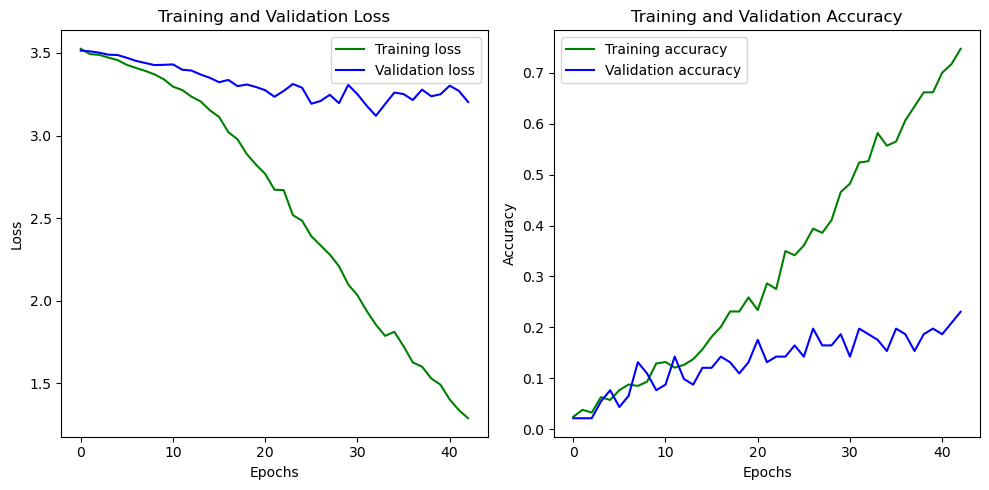

In [315]:
train_loss = hist.history["loss"]
val_loss = hist.history["val_loss"]
train_acc = hist.history["accuracy"]
val_acc = hist.history["val_accuracy"]

# Plotting loss
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(train_loss, "g", label="Training loss")
plt.plot(val_loss, "b", label="Validation loss")
plt.title("Training and Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

# Plotting accuracy
plt.subplot(1, 2, 2)
plt.plot(train_acc, "g", label="Training accuracy")
plt.plot(val_acc, "b", label="Validation accuracy")
plt.title("Training and Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()

plt.tight_layout()
plt.show()

---

# Test Transformer

In [345]:
def transformer_encoder(inputs, mask_input, head_size, num_heads, ff_dim, dropout=0):
    # Attention and Normalization
    x = keras.layers.MultiHeadAttention(
        key_dim=head_size, num_heads=num_heads, dropout=dropout
    )(inputs, inputs, attention_mask=mask_input)
    x = keras.layers.Dropout(dropout)(x)
    x = keras.layers.LayerNormalization(epsilon=1e-6)(x)
    res = x + inputs

    # Feed Forward Part
    x = keras.layers.Conv1D(filters=ff_dim, kernel_size=1, activation="relu")(res)
    x = keras.layers.Dropout(dropout)(x)
    x = keras.layers.Conv1D(filters=inputs.shape[-1], kernel_size=1)(x)
    x = keras.layers.LayerNormalization(epsilon=1e-6)(x)
    return x + res

In [349]:
def build_model(
    head_size,
    num_heads,
    ff_dim,
    num_transformer_blocks,
    mlp_units,
    dropout=0,
    mlp_dropout=0,
):
    inputs = keras.Input((MAX_SEQ_LENGTH, NUM_FEATURES))
    mask_input = keras.Input((MAX_SEQ_LENGTH,), dtype="bool")
    x = inputs
    for _ in range(num_transformer_blocks):
        x = transformer_encoder(x, mask_input, head_size, num_heads, ff_dim, dropout)

    x = keras.layers.GlobalAveragePooling1D(data_format="channels_last")(x)
    for dim in mlp_units:
        x = keras.layers.Dense(dim, activation="relu")(x)
        x = keras.layers.Dropout(mlp_dropout)(x)
    outputs = keras.layers.Dense(len(label_processor.get_vocabulary()), activation="softmax")(x)
    return keras.Model([inputs, mask_input], outputs)

In [350]:
model = build_model(
    head_size=256,
    num_heads=4,
    ff_dim=4,
    num_transformer_blocks=4,
    mlp_units=[128],
    mlp_dropout=0.4,
    dropout=0.25,
)

model.compile(
    loss="sparse_categorical_crossentropy",
    optimizer=keras.optimizers.Adam(learning_rate=1e-4),
    metrics=["sparse_categorical_accuracy"],
)
model.summary()

Model: "functional_13"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_34      │ (None, 50, 2048)  │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_35      │ (None, 50)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 50, 2048)  │  8,393,728 │ input_layer_34[0… │
│ (MultiHeadAttentio… │                   │            │ input_layer_34[0… │
│                     │                   │            │ input_layer_35[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_64          │ (None, 50, 2048)  │          0 │ multi_head_atten… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 50, 2048)  │      4,096 │ dropout_64[0][0]  │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_33 (Add)        │ (None, 50, 2048)  │          0 │ layer_normalizat… │
│                     │                   │            │ input_layer_34[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_33 (Conv1D)  │ (None, 50, 4)     │      8,196 │ add_33[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_65          │ (None, 50, 4)     │          0 │ conv1d_33[0][0]   │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_34 (Conv1D)  │ (None, 50, 2048)  │     10,240 │ dropout_65[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 50, 2048)  │      4,096 │ conv1d_34[0][0]   │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_34 (Add)        │ (None, 50, 2048)  │          0 │ layer_normalizat… │
│                     │                   │            │ add_33[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 50, 2048)  │  8,393,728 │ add_34[0][0],     │
│ (MultiHeadAttentio… │                   │            │ add_34[0][0],     │
│                     │                   │            │ input_layer_35[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_67          │ (None, 50, 2048)  │          0 │ multi_head_atten… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 50, 2048)  │      4,096 │ dropout_67[0][0]  │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_35 (Add)        │ (None, 50, 2048)  │          0 │ layer_normalizat… │
│                     │                   │            │ add_34[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_35 (Conv1D)  │ (None, 50, 4)     │      8,196 │ add_35[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_68          │ (None, 50, 4)     │          0 │ conv1d_35[0][0]   │
│ (Dropout)           │                   │            │                 

 Total params: 33,948,082 (129.50 MB)

 Trainable params: 33,948,082 (129.50 MB)

 Non-trainable params: 0 (0.00 B)

In [351]:
callbacks = [keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)]

In [357]:
for layer in model.layers:
    print(layer.name)
    print(layer.get_config())


input_layer_34
{'batch_shape': (None, 50, 2048), 'dtype': 'float32', 'sparse': False, 'name': 'input_layer_34'}
input_layer_35
{'batch_shape': (None, 50), 'dtype': 'bool', 'sparse': False, 'name': 'input_layer_35'}
multi_head_attention_18
{'name': 'multi_head_attention_18', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None}, 'num_heads': 4, 'key_dim': 256, 'value_dim': 256, 'dropout': 0.25, 'use_bias': True, 'output_shape': None, 'attention_axes': (1,), 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None, 'seed': None}
dropout_64
{'name': 'dropout_64', 'trainable': True, 'dt

In [352]:
model.fit(
    [X_train[0], X_train[1]],
    y_train,
    validation_data=([X_val[0], X_val[1]], y_val),
    epochs=150,
    batch_size=64,
    callbacks=callbacks,
)

Epoch 1/150


2024-09-10 18:49:38.206101: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: INVALID_ARGUMENT: Incompatible shapes: [64,4,50,50] vs. [1,1,64,50]
	 [[{{function_node __inference_one_step_on_data_2148770}}{{node functional_13_1/multi_head_attention_18_1/softmax_17_1/add}}]]


InvalidArgumentError: Graph execution error:

Detected at node functional_13_1/multi_head_attention_18_1/softmax_17_1/add defined at (most recent call last):
  File "<frozen runpy>", line 198, in _run_module_as_main

  File "<frozen runpy>", line 88, in _run_code

  File "/Users/hanhf/anaconda3/lib/python3.12/site-packages/ipykernel_launcher.py", line 17, in <module>

  File "/Users/hanhf/anaconda3/lib/python3.12/site-packages/traitlets/config/application.py", line 1075, in launch_instance

  File "/Users/hanhf/anaconda3/lib/python3.12/site-packages/ipykernel/kernelapp.py", line 701, in start

  File "/Users/hanhf/anaconda3/lib/python3.12/site-packages/tornado/platform/asyncio.py", line 205, in start

  File "/Users/hanhf/anaconda3/lib/python3.12/asyncio/base_events.py", line 641, in run_forever

  File "/Users/hanhf/anaconda3/lib/python3.12/asyncio/base_events.py", line 1987, in _run_once

  File "/Users/hanhf/anaconda3/lib/python3.12/asyncio/events.py", line 88, in _run

  File "/Users/hanhf/anaconda3/lib/python3.12/site-packages/ipykernel/kernelbase.py", line 534, in dispatch_queue

  File "/Users/hanhf/anaconda3/lib/python3.12/site-packages/ipykernel/kernelbase.py", line 523, in process_one

  File "/Users/hanhf/anaconda3/lib/python3.12/site-packages/ipykernel/kernelbase.py", line 429, in dispatch_shell

  File "/Users/hanhf/anaconda3/lib/python3.12/site-packages/ipykernel/kernelbase.py", line 767, in execute_request

  File "/Users/hanhf/anaconda3/lib/python3.12/site-packages/ipykernel/ipkernel.py", line 429, in do_execute

  File "/Users/hanhf/anaconda3/lib/python3.12/site-packages/ipykernel/zmqshell.py", line 549, in run_cell

  File "/Users/hanhf/anaconda3/lib/python3.12/site-packages/IPython/core/interactiveshell.py", line 3075, in run_cell

  File "/Users/hanhf/anaconda3/lib/python3.12/site-packages/IPython/core/interactiveshell.py", line 3130, in _run_cell

  File "/Users/hanhf/anaconda3/lib/python3.12/site-packages/IPython/core/async_helpers.py", line 129, in _pseudo_sync_runner

  File "/Users/hanhf/anaconda3/lib/python3.12/site-packages/IPython/core/interactiveshell.py", line 3334, in run_cell_async

  File "/Users/hanhf/anaconda3/lib/python3.12/site-packages/IPython/core/interactiveshell.py", line 3517, in run_ast_nodes

  File "/Users/hanhf/anaconda3/lib/python3.12/site-packages/IPython/core/interactiveshell.py", line 3577, in run_code

  File "/var/folders/tr/hcy2d3h1783c2lxmmvmz0dmc0000gn/T/ipykernel_4183/3528756.py", line 1, in <module>

  File "/Users/hanhf/anaconda3/lib/python3.12/site-packages/keras/src/utils/traceback_utils.py", line 117, in error_handler

  File "/Users/hanhf/anaconda3/lib/python3.12/site-packages/keras/src/backend/tensorflow/trainer.py", line 320, in fit

  File "/Users/hanhf/anaconda3/lib/python3.12/site-packages/keras/src/backend/tensorflow/trainer.py", line 121, in one_step_on_iterator

  File "/Users/hanhf/anaconda3/lib/python3.12/site-packages/keras/src/backend/tensorflow/trainer.py", line 108, in one_step_on_data

  File "/Users/hanhf/anaconda3/lib/python3.12/site-packages/keras/src/backend/tensorflow/trainer.py", line 51, in train_step

  File "/Users/hanhf/anaconda3/lib/python3.12/site-packages/keras/src/utils/traceback_utils.py", line 117, in error_handler

  File "/Users/hanhf/anaconda3/lib/python3.12/site-packages/keras/src/layers/layer.py", line 901, in __call__

  File "/Users/hanhf/anaconda3/lib/python3.12/site-packages/keras/src/utils/traceback_utils.py", line 117, in error_handler

  File "/Users/hanhf/anaconda3/lib/python3.12/site-packages/keras/src/ops/operation.py", line 46, in __call__

  File "/Users/hanhf/anaconda3/lib/python3.12/site-packages/keras/src/utils/traceback_utils.py", line 156, in error_handler

  File "/Users/hanhf/anaconda3/lib/python3.12/site-packages/keras/src/models/functional.py", line 175, in call

  File "/Users/hanhf/anaconda3/lib/python3.12/site-packages/keras/src/ops/function.py", line 171, in _run_through_graph

  File "/Users/hanhf/anaconda3/lib/python3.12/site-packages/keras/src/models/functional.py", line 560, in call

  File "/Users/hanhf/anaconda3/lib/python3.12/site-packages/keras/src/utils/traceback_utils.py", line 117, in error_handler

  File "/Users/hanhf/anaconda3/lib/python3.12/site-packages/keras/src/layers/layer.py", line 901, in __call__

  File "/Users/hanhf/anaconda3/lib/python3.12/site-packages/keras/src/utils/traceback_utils.py", line 117, in error_handler

  File "/Users/hanhf/anaconda3/lib/python3.12/site-packages/keras/src/ops/operation.py", line 46, in __call__

  File "/Users/hanhf/anaconda3/lib/python3.12/site-packages/keras/src/utils/traceback_utils.py", line 156, in error_handler

  File "/Users/hanhf/anaconda3/lib/python3.12/site-packages/keras/src/layers/attention/multi_head_attention.py", line 492, in call

  File "/Users/hanhf/anaconda3/lib/python3.12/site-packages/keras/src/layers/attention/multi_head_attention.py", line 436, in _compute_attention

  File "/Users/hanhf/anaconda3/lib/python3.12/site-packages/keras/src/layers/attention/multi_head_attention.py", line 399, in _masked_softmax

  File "/Users/hanhf/anaconda3/lib/python3.12/site-packages/keras/src/utils/traceback_utils.py", line 117, in error_handler

  File "/Users/hanhf/anaconda3/lib/python3.12/site-packages/keras/src/layers/layer.py", line 901, in __call__

  File "/Users/hanhf/anaconda3/lib/python3.12/site-packages/keras/src/utils/traceback_utils.py", line 117, in error_handler

  File "/Users/hanhf/anaconda3/lib/python3.12/site-packages/keras/src/ops/operation.py", line 46, in __call__

  File "/Users/hanhf/anaconda3/lib/python3.12/site-packages/keras/src/utils/traceback_utils.py", line 156, in error_handler

  File "/Users/hanhf/anaconda3/lib/python3.12/site-packages/keras/src/layers/activations/softmax.py", line 56, in call

Incompatible shapes: [64,4,50,50] vs. [1,1,64,50]
	 [[{{node functional_13_1/multi_head_attention_18_1/softmax_17_1/add}}]] [Op:__inference_one_step_on_iterator_2149221]

In [336]:
model.evaluate(X_test[0], y_test, verbose=1)

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 3.5359 - sparse_categorical_accuracy: 0.0300 


[3.5341920852661133, 0.029411764815449715]

---

# Save Model

In [219]:
model.export(MODEL_DIR)

INFO:tensorflow:Assets written to: models/asl_words_classifier/assets


INFO:tensorflow:Assets written to: models/asl_words_classifier/assets


Saved artifact at 'models/asl_words_classifier/'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): List[TensorSpec(shape=(None, 50, 2048), dtype=tf.float32, name='keras_tensor_997'), TensorSpec(shape=(None, 50), dtype=tf.bool, name='keras_tensor_998')]
Output Type:
  TensorSpec(shape=(None, 18), dtype=tf.float32, name=None)
Captures:
  21631955408: TensorSpec(shape=(), dtype=tf.resource, name=None)
  21631954832: TensorSpec(shape=(), dtype=tf.resource, name=None)
  21631958288: TensorSpec(shape=(), dtype=tf.resource, name=None)
  14695286544: TensorSpec(shape=(), dtype=tf.resource, name=None)
  21631955024: TensorSpec(shape=(), dtype=tf.resource, name=None)
  21631956944: TensorSpec(shape=(), dtype=tf.resource, name=None)
  14695285776: TensorSpec(shape=(), dtype=tf.resource, name=None)
  14695287120: TensorSpec(shape=(), dtype=tf.resource, name=None)
  14695287312: TensorSpec(shape=(), dtype=tf.resource, name=None)
  14695287888: TensorSpec(shape=

In [223]:
# Convert the model
converter = tf.lite.TFLiteConverter.from_saved_model(
    MODEL_DIR
)  # path to the SavedModel directory
converter.experimental_enable_resource_variables = True
converter.target_spec.supported_ops = [
    tf.lite.OpsSet.TFLITE_BUILTINS,  # Enable TensorFlow Lite ops
    tf.lite.OpsSet.SELECT_TF_OPS,  # Enable TensorFlow ops
]
tflite_model = converter.convert()


# Save the model.
with open("models/asl_words_2_classifier.tflite", "wb") as f:
    f.write(tflite_model)

W0000 00:00:1725008541.887376   86912 tf_tfl_flatbuffer_helpers.cc:390] Ignored output_format.
W0000 00:00:1725008541.887387   86912 tf_tfl_flatbuffer_helpers.cc:393] Ignored drop_control_dependency.
2024-08-30 19:02:22.039047: W tensorflow/compiler/mlir/lite/flatbuffer_export.cc:2996] TFLite interpreter needs to link Flex delegate in order to run the model since it contains the following Select TFop(s):
Flex ops: FlexTensorListReserve, FlexTensorListSetItem, FlexTensorListStack
Details:
	tf.TensorListReserve(tensor<2xi32>, tensor<i32>) -> (tensor<!tf_type.variant<tensor<?x100xf32>>>) : {device = ""}
	tf.TensorListReserve(tensor<2xi32>, tensor<i32>) -> (tensor<!tf_type.variant<tensor<?x50xf32>>>) : {device = ""}
	tf.TensorListSetItem(tensor<!tf_type.variant<tensor<?x100xf32>>>, tensor<i32>, tensor<?x100xf32>) -> (tensor<!tf_type.variant<tensor<?x100xf32>>>) : {device = "", resize_if_index_out_of_bounds = false}
	tf.TensorListSetItem(tensor<!tf_type.variant<tensor<?x50xf32>>>, tensor<i3